In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression

import yfinance as yf
from datetime import date, timedelta

<h1> Problem 1 </h1>

We first integrate the given dynamics to get the $X$ and $\dot{X}$ matrices. Then we apply the SINDy algorithm on the basis $\{x, y, z, x^2, y^2, z^2, \sin(x), \sin(y), \sin(z), e^x, e^y, e^z, \cos(x), \cos(y), \cos(z)\}$.

In [12]:
df = yf.download(["^GSPC", "^TNX", "JPY=X"], start=date.today() - timedelta(5000), end=date.today() + timedelta(1), interval='1d')
df = df['Adj Close'].resample('D').last().dropna()
df

[*********************100%%**********************]  3 of 3 completed


Ticker,JPY=X,^GSPC,^TNX
Date,,,
2010-06-14,91.620003,1089.630005,3.275
2010-06-15,91.473999,1115.229980,3.310
2010-06-16,91.396004,1114.609985,3.282
2010-06-17,90.839996,1116.040039,3.190
2010-06-18,90.699997,1117.510010,3.223
...,...,...,...
2024-02-13,149.404999,4953.169922,4.316
2024-02-14,150.723999,5000.620117,4.267
2024-02-15,150.544006,5029.729980,4.240


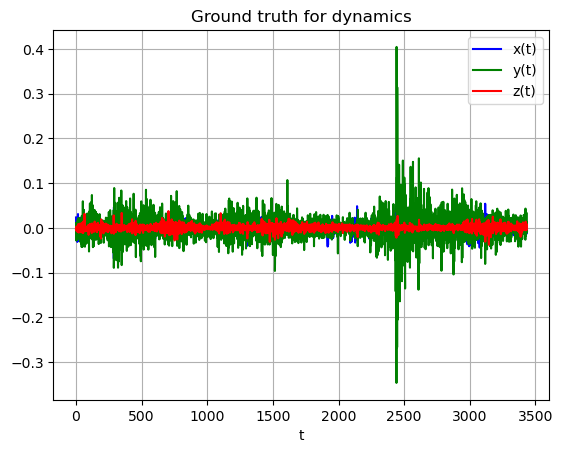

Estimate:  [[ 0.  0. -0. -0.  0. -0.  0.  0. -0.]
 [ 0.  0. -0. -0.  0. -0.  0.  0. -0.]
 [-0.  0.  0.  0. -0.  0. -0.  0.  0.]]


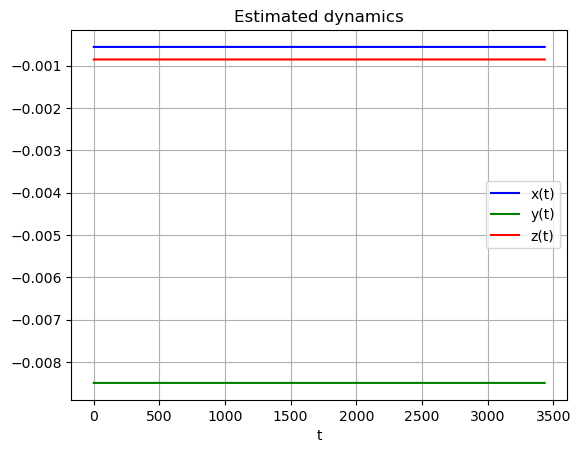

In [18]:
stocks = ["^GSPC", "^TNX", "JPY=X"]

transform = lambda x: np.log(x).diff().dropna()

t = range(len(df)-1)
plt.plot(t, transform(df[stocks[0]]), 'b', label='x(t)')
plt.plot(t, transform(df[stocks[1]]), 'g', label='y(t)')
plt.plot(t, transform(df[stocks[2]]), 'r', label='z(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.title("Ground truth for dynamics")
plt.grid()
plt.show()

X = transform(df[stocks]).to_numpy()[1:, :]
X_dot = transform(df[stocks]).diff().dropna().to_numpy()
transforms = lambda x: np.concatenate([x,
                                       np.square(x),
                                       np.sin(x),
                                       ],
                                      axis=None if len(x.shape)== 1 else 1)
theta_X = transforms(X)

alpha = .2
x_model, y_model, z_model = Lasso(alpha=alpha, fit_intercept=False), Lasso(alpha=alpha, fit_intercept=False), Lasso(alpha=alpha, fit_intercept=False)
x_model.fit(theta_X, X_dot[:, 0])
y_model.fit(theta_X, X_dot[:, 1])
z_model.fit(theta_X, X_dot[:, 2])
estimate = np.vstack([x_model.coef_, y_model.coef_, z_model.coef_])
print("Estimate: ", estimate)

sol = odeint(lambda x, t: estimate@transforms(x), X[0, :], t)

plt.plot(t, sol[:, 0], 'b', label='x(t)')
plt.plot(t, sol[:, 1], 'g', label='y(t)')
plt.plot(t, sol[:, 2], 'r', label='z(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.title("Estimated dynamics")
plt.grid()
plt.show()




<h1> Problem 2 </h1>

The learned dynamics we have from part a is $$
\dot{X}=
  \begin{bmatrix}
    -1.9 & 0 & 0.98 \\
    0.05 & 0 & -1.54 \\
    -0.9 & 0 & 2.98
  \end{bmatrix} X $$

By discretizing $X, \dot{X}$, we can set up a convex optimization that determines $\alpha(t)$ for all our timesteps.
Then, we can represent this as a linear program with $\alpha(\delta t)$ and $w(\delta t)$ being the variables, the dynamics being the constraints, and the loss functional being the objective function. We set $\delta = 0.05$ for the purposes of this problem.

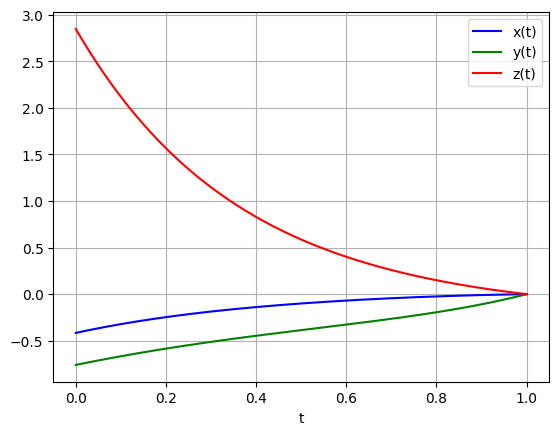

In [ ]:
import cvxpy as cp

def plot_alpha(initial_condition):
  num_steps = 200
  step_size = 1.0/200

  a_vars = [cp.Variable(3) for i in range(num_steps)]
  w_vars = [cp.Variable(3) for i in range(num_steps)]
  dynamics = cp.Constant(estimate)
  Q, R = cp.Constant(np.diag([0.5, 1, 0.25])), cp.Constant(np.diag([1.5, 0.5, 0.5]))

  def constraints():
    ret = []
    for i in range(1, len(w_vars)):
      ret += [w_vars[i] - w_vars[i-1] - step_size*(dynamics@w_vars[i-1] + a_vars[i-1]) == 0]
    ret += [w_vars[0][i] == initial_condition[i] for i in range(3)]
    return ret

  def objective():
    ret = 0
    for i in range(len(w_vars)):
      ret += step_size*(cp.quad_form(w_vars[i], Q) + cp.quad_form(a_vars[i], R))
    return cp.Minimize(0.5*ret)

  ob = objective()
  cons = constraints()
  problem = cp.Problem(ob, cons)
  problem.solve()

  a_vars = np.array([i.value for i in a_vars])
  w_vars = np.array([i.value for i in w_vars])
  t = np.linspace(0, 1, 200)
  plt.plot(t, a_vars[:, 0], 'b', label='x(t)')
  plt.plot(t, a_vars[:, 1], 'g', label='y(t)')
  plt.plot(t, a_vars[:, 2], 'r', label='z(t)')
  plt.legend(loc='best')
  plt.xlabel('t')
  plt.grid()
  plt.show()

plot_alpha(initial)